<a href="https://colab.research.google.com/github/Preetham1928/Reinforcement_learning_Lab/blob/main/RL_Assg_3_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3. Implementing Monte Carlo Methods for Policy Evaluation and Control


Episode 100000/500000
Episode 200000/500000
Episode 300000/500000
Episode 400000/500000
Episode 500000/500000
Q-values for state (20, 10, False) : [ 0.43237231 -0.83603757]


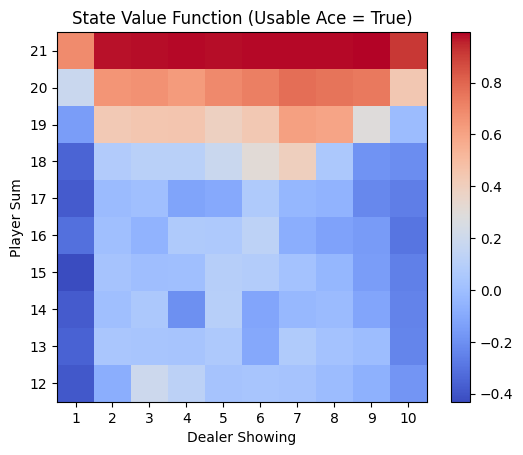

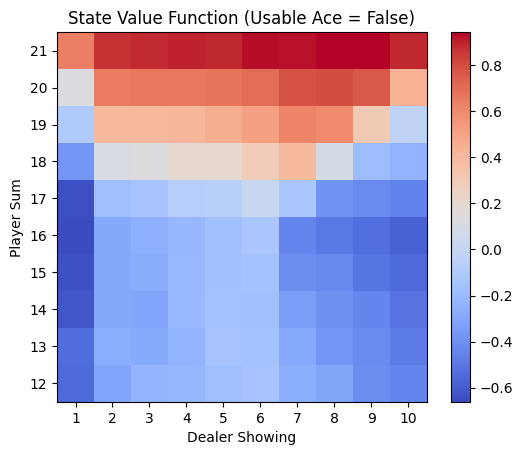

In [11]:
!pip install gymnasium

#Monte Carlo Policy Evaluation & Control (ε-greedy) – Blackjack Example
import gymnasium as gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Corrected environment instantiation
env = gym.make("Blackjack-v1", sab=True)

# ε-greedy policy
def epsilon_greedy_policy(Q, state, nA, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(nA)
    else:
        # Handle states not yet in Q
        if state not in Q:
            return np.random.choice(nA)
        return np.argmax(Q[state])

# Generate an episode following policy π
def generate_episode(Q, epsilon, nA):
    episode = []
    # Updated env.reset() for Gymnasium
    state, _ = env.reset()
    done = False
    while not done:
        action = epsilon_greedy_policy(Q, state, nA, epsilon)
        # Updated env.step() for Gymnasium
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode.append((state, action, reward))
        state = next_state
    return episode

# Monte Carlo Control with ε-greedy
def mc_control_epsilon_greedy(num_episodes=500000, gamma=1.0, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Q[state][action]
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    for i_episode in range(1, num_episodes + 1):
        # Ensure epsilon decays or remains constant based on desired behavior
        current_epsilon = epsilon # Simple constant epsilon for this example

        episode = generate_episode(Q, current_epsilon, env.action_space.n)
        G = 0
        visited_states_actions = set() # Track (state, action) pairs visited in this episode

        # Work backwards through episode
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward

            # First-visit MC
            if (state, action) not in visited_states_actions:
                visited_states_actions.add((state, action))
                returns_sum[(state, action)] += G
                returns_count[(state, action)] += 1.0 # Use 1.0 for float division
                Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]

        # Optional: print progress
        if i_episode % 100000 == 0:
            print(f"Episode {i_episode}/{num_episodes}")

    policy = {s: np.argmax(a) for s, a in Q.items()}
    return policy, Q

# Run the MC Control
final_policy, final_Q = mc_control_epsilon_greedy()

# Example: View Q-value for a specific state
sample_state = (20, 10, False)  # (player_sum, dealer_card, usable_ace)
# Check if the sample_state exists in final_Q before accessing
if sample_state in final_Q:
    print("Q-values for state", sample_state, ":", final_Q[sample_state])
else:
    print("State", sample_state, "not visited during training.")


#Optional Visualization of State Value

def plot_value_function(Q, usable_ace=True):
    # Ensure the shape matches the states considered
    value_fn = np.zeros((10, 10)) # player_sum (12-21) vs dealer_card (1-10)
    for player_sum in range(12, 22):
        for dealer_card in range(1, 11):
            state = (player_sum, dealer_card, usable_ace)
            if state in Q:
                # Use np.max as it's Q-values, we want the value of the best action in that state
                value_fn[player_sum - 12, dealer_card - 1] = np.max(Q[state])
            else:
                # Assign a default value (e.g., 0 or a small number) for unvisited states
                value_fn[player_sum - 12, dealer_card - 1] = 0 # Or a more appropriate default

    plt.imshow(value_fn, cmap='coolwarm', origin='lower', extent=[0.5, 10.5, 11.5, 21.5]) # Adjust extent for labels
    plt.colorbar()
    plt.xlabel("Dealer Showing")
    plt.ylabel("Player Sum")
    plt.title("State Value Function (Usable Ace = " + str(usable_ace) + ")")
    plt.xticks(np.arange(1, 11)) # Set ticks for dealer card values
    plt.yticks(np.arange(12, 22)) # Set ticks for player sum values
    plt.show()

# Plot both with and without usable ace
plot_value_function(final_Q, usable_ace=True)
plot_value_function(final_Q, usable_ace=False)

In [16]:
import numpy as np
from collections import defaultdict
import gymnasium as gym # Import gymnasium
import random
from typing import Dict, Tuple, List

# ==============================
# Monte Carlo: Policy Evaluation
# ==============================
def mc_prediction(env, policy, num_episodes=5000, gamma=1.0):
    """
    Monte Carlo Prediction (First-Visit).
    Estimates V(s) for a given policy.

    Args:
        env: episodic environment with reset() and step(a)
        policy: function mapping state -> action probabilities
        num_episodes: number of episodes
        gamma: discount factor

    Returns:
        V (dict): state-value function
    """
    V = defaultdict(float)
    returns_count = defaultdict(int)

    for _ in range(num_episodes):
        # Use the local generate_episode that takes a policy function
        episode = generate_episode(env, policy)
        G = 0
        visited = set()

        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = gamma * G + r
            if s not in visited:
                visited.add(s)
                returns_count[s] += 1
                V[s] += (G - V[s]) / returns_count[s] # Correct update rule
    return V


# ============================
# Monte Carlo: Control (On-Policy)
# ============================
def mc_control_epsilon_soft(env, num_episodes=5000, gamma=1.0,
                            epsilon_start=1.0, epsilon_end=0.05):
    """
    Monte Carlo Control with epsilon-soft policy (On-policy).
    Improves Q(s,a) until near-optimal.

    Args:
        env: episodic environment with reset() and step(a)
        num_episodes: number of episodes
        gamma: discount factor
        epsilon_start: initial exploration rate
        epsilon_end: final exploration rate

    Returns:
        Q (dict): action-value function
        policy (dict): greedy policy derived from Q
        V (dict): state-value function
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # Initialize Q with zeros
    returns_count = defaultdict(int)

    epsilons = np.linspace(epsilon_start, epsilon_end, num_episodes)

    for i in range(num_episodes):
        epsilon = float(epsilons[i])
        # Corrected policy generation to use make_epsilon_greedy_policy from this cell
        policy = make_epsilon_greedy_policy(Q, env.action_space.n, epsilon)

        # Corrected episode generation to use generate_episode from this cell
        episode = generate_episode(env, policy)

        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = gamma * G + r
            if (s, a) not in visited:
                visited.add((s, a))
                returns_count[(s, a)] += 1
                # Ensure the state is in Q before updating
                if s in Q:
                  Q[s][a] += (G - Q[s][a]) / returns_count[(s, a)] # Correct update rule

    # Derive greedy policy
    policy_greedy = {}
    V = {}
    # Iterate over states present in Q using a copy of keys
    for s in list(Q.keys()):
        # Ensure state is still in Q in case it was somehow removed (though unlikely with defaultdict)
        if s in Q:
            qs = [Q[s][a] for a in range(env.action_space.n)]
            best_a = int(np.argmax(qs))
            probs = np.zeros(env.action_space.n)
            probs[best_a] = 1.0
            policy_greedy[s] = probs
            V[s] = np.max(qs)
    return Q, policy_greedy, V


# ==========================
# Helper functions (Uncommented and used locally)
# ==========================
def make_epsilon_greedy_policy(Q: Dict, nA: int, epsilon: float):
    """Return a policy function that takes state and returns action probabilities."""
    def policy_fn(state):
        probs = np.ones(nA) * (epsilon / nA)
        # Ensure state is in Q before accessing
        if state in Q:
            q_vals = Q[state]
            best_a = np.argmax(q_vals)
            probs[best_a] += (1.0 - epsilon)
        else:
             # If state is not in Q, return uniform probabilities for exploration
            probs = np.ones(nA) / nA
        return probs
    return policy_fn

def generate_episode(env, policy):
    """Generate an episode: returns list of (state, action, reward). Uses policy as action-prob function."""
    episode = []
    state, _ = env.reset() # Updated env.reset() for Gymnasium
    done = False
    while not done:
        probs = policy(state)
        action = np.random.choice(len(probs), p=probs)
        next_state, reward, terminated, truncated, _ = env.step(action) # Updated env.step() for Gymnasium
        done = terminated or truncated
        episode.append((state, action, reward))
        state = next_state
    return episode


# Use the environment from the previous cell
# env = Gridworld4x4()  # or BlackjackEnv()

# --- Policy Evaluation for a random policy ---
# Need a policy function that takes state as input
random_policy = lambda s: np.ones(env.action_space.n) / env.action_space.n
V_est = mc_prediction(env, random_policy, num_episodes=5000)
print("Value Function under Random Policy:", V_est)

# --- Policy Improvement with MC Control ---
Q, optimal_policy, V_star = mc_control_epsilon_soft(env, num_episodes=10000)
print("Optimal Policy:", optimal_policy)
print("Optimal Value Function:", V_star)

Value Function under Random Policy: defaultdict(<class 'float'>, {(12, 4, 0): -0.6444444444444445, (15, 4, 0): -0.4130434782608695, (14, 10, 0): -0.6125, (20, 3, 0): -0.26984126984126994, (19, 3, 0): -0.4062499999999999, (12, 3, 0): -0.7692307692307692, (17, 6, 0): -0.3548387096774194, (16, 6, 0): -0.24242424242424243, (13, 5, 0): -0.3529411764705882, (20, 10, 0): -0.21794871794871787, (10, 10, 0): -0.40506329113924067, (8, 8, 0): -0.5333333333333333, (21, 2, 1): 6.245004513516506e-17, (20, 5, 0): -0.21568627450980385, (19, 5, 0): 0.21875, (14, 2, 0): -0.27586206896551724, (13, 10, 0): -0.551912568306011, (15, 7, 0): -0.48888888888888893, (19, 1, 0): -0.38235294117647056, (16, 7, 0): -0.4516129032258064, (17, 7, 0): -0.3703703703703703, (14, 7, 0): -0.39130434782608703, (12, 3, 1): 0.0, (21, 8, 1): 0.22727272727272727, (21, 9, 0): -0.1, (16, 9, 0): -0.9285714285714286, (14, 9, 0): -0.6190476190476191, (17, 10, 0): -0.5705128205128207, (16, 10, 0): -0.7123287671232875, (6, 10, 0): -0.5,